In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/HSE_DL_2021/06_week

/content/gdrive/My Drive/HSE_DL_2021/06_week


# Наша первая свёрточная нейросеть 

Пришло время построить нашу первую свёрточную нейросеть. Будем использовать для этого датасет [fashion MNIST.](https://www.cs.toronto.edu/~kriz/cifar.html) Набор данных включает в себя изображения рукописных цифр.  

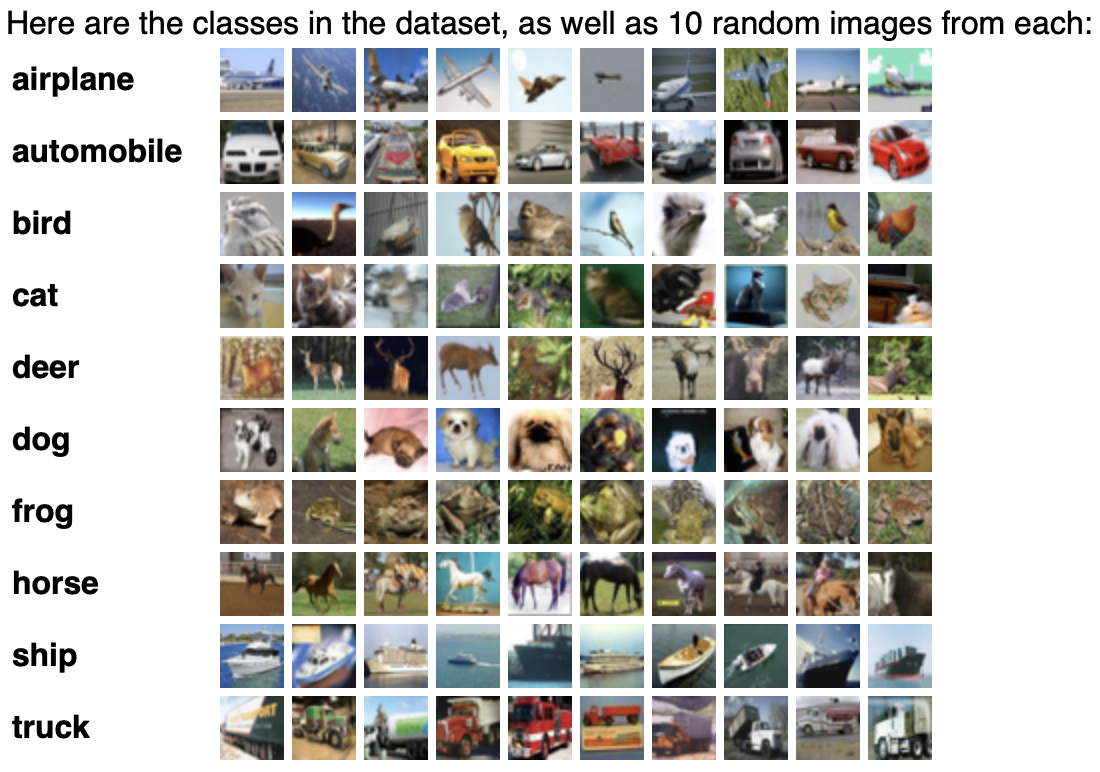

In [3]:
from IPython import display
display.Image('images/Fashion.png', retina=True)

In [22]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.__version__

'1.9.0+cu111'

In [64]:
import numpy as np
import random
from tqdm import tqdm
import seaborn as sns
sns.set_context('talk')  # это оформление чтобы графики были красивые

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Смотрим на данные 

Скачаеми приготовим данные. Буквально через минуту в наших руках окажутся $60 000$ картинок размера $28 \times 28$.

In [24]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                                             download=True, 
                                             transform=transforms.ToTensor())
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, 
                                            download=True, 
                                            transform=transforms.ToTensor())

In [25]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

<class 'torchvision.datasets.mnist.FashionMNIST'>
torch.Size([1, 28, 28])


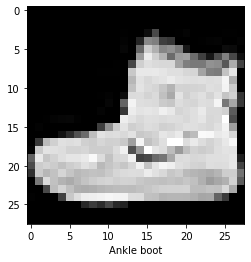

In [26]:
print(type(trainset))
print(trainset[0][0].shape)

plt.grid(False)
plt.imshow(trainset[0][0].squeeze(), cmap = 'gray')
plt.xlabel(class_names[trainset[0][1]])
plt.show()

Нарисуем несколько рандомных картинок из тренировочной выборки. 

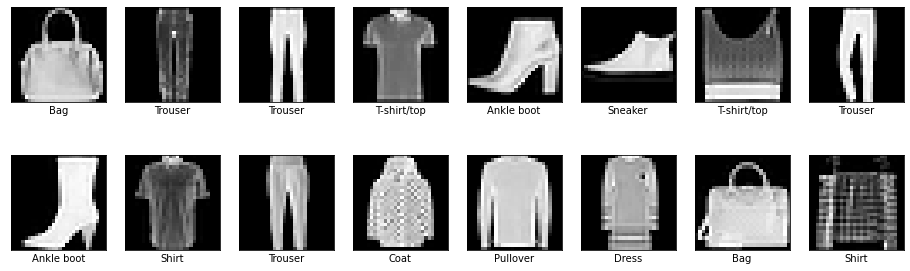

In [27]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(trainset))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(trainset[random_index][0].squeeze(), cmap = 'gray')
        ax.set_xlabel(class_names[trainset[random_index][1]])
plt.show()

## 2.  Выбираем для нашей нейросети архитектуру

Свёрточная нейронная сеть строится из нескольких разных типов слоёв: 

* [Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) - Конволюция
* [MaxPooling2D](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveMaxPool2d.html?highlight=maxpool#torch.nn.AdaptiveMaxPool2d) - макспулинг
* [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html?highlight=flatten#torch.nn.Flatten) - разворачивает картинку в вектор 
* [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=nn%20linear#torch.nn.Linear) - полносвязный слой (fully-connected layer)
* [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=nn%20relu#torch.nn.ReLU) - функция активации
* [LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html?highlight=leaky#torch.nn.LeakyReLU) - leaky relu активация
* [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=nn%20dropout#torch.nn.Dropout) - дропаут.


В модели, которую мы определим ниже, на вход будет идти тензоры размера __(None, 28, 28, 1)__ и __(None, 10)__. На выходе мы будем получать вероятноть того, что объект относится к конкретному классу. Разменость __None__ заготовлена для размерности батча. 

## 2.1 Полносвязная сетка 

Соберём полносвязную сетку с нашей предыдущей пары

**Важный момент:** после последнего FC слоя `softmax` не вызывается, т.к. он заложен внутрь [`nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [28]:
RANDOM_SEED = 1234
torch.manual_seed(RANDOM_SEED)

In [29]:
class FC(nn.Module):
    def __init__(self): 
        super().__init__()
        self.classifier = nn.Sequential(nn.Linear(784, 64),  # 28 x 28 = 784
                                        nn.BatchNorm1d(64),
                                        nn.ReLU(),
                                        nn.Linear(64, 32),
                                        nn.BatchNorm1d(32),
                                        nn.ReLU(),
                                        nn.Linear(32, 16),
                                        nn.BatchNorm1d(16),
                                        nn.ReLU(),
                                        nn.Linear(16, 10),
                                    )
             
    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        # батч сайз сохранить
        logits = self.classifier(x)
        # probs = F.softmax(logits, dim=1) # if no dim is given, then a warning will appear
        return logits

In [30]:
batch_size = 512
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [31]:
trainset.data.shape

torch.Size([60000, 28, 28])

In [32]:
print(iter(trainloader).next()[0].shape)

torch.Size([512, 1, 28, 28])


In [43]:
device = 'cpu'  # torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model_fc = FC()
model_fc.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model_fc.parameters(), lr=0.01)

cpu


In [44]:
def train_nn(trainloader, model, opt, loss_fn, device):
    running_loss = []

    model.train()
    correct_pred = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)

        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs.cpu(), labels)
        loss.backward()
        opt.step()

        correct_pred += (outputs.cpu().argmax(dim=1) == labels).sum()
        
        running_loss.append(loss.item())

    return model, running_loss, correct_pred


def eval_nn(testloader, model, loss_fn, device):
    running_loss_test = []

    model.eval()
    correct_pred = 0
    predicts = np.array([])
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)

        outputs = model(inputs)
        predicts = np.append(predicts, outputs.cpu().argmax(dim=1).numpy())
        loss = loss_fn(outputs.cpu(), labels)

        correct_pred += (outputs.cpu().argmax(dim=1) == labels).sum()

        running_loss_test.append(loss.item())
    return running_loss_test, predicts.astype(int), correct_pred

In [45]:
len(trainloader.dataset)

60000

In [62]:
def training_loop(model, trainloader, testloader, opt, loss_fn, device, max_epochs=20):
    len_train = len(trainloader.dataset)
    len_test = len(testloader.dataset)

    loss_arr = []
    loss_arr_test = []
    acc = []
    acc_test = []

    for epoch in range(max_epochs):        
        model, running_loss, correct_pred = train_nn(trainloader, model, opt, loss_fn, device)
        running_loss_test, _, correct_pred_test = eval_nn(testloader, model, loss_fn, device)

        loss_arr.append(np.mean(running_loss))
        loss_arr_test.append(np.mean(running_loss_test))
        
        acc.append(correct_pred / len_train)
        acc_test.append(correct_pred_test / len_test)

        if epoch % 4 == 0:
            print(f'Epoch: {epoch}\t'
                  f'Train loss: {loss_arr[-1]:.5f}\t'
                  f'Test loss: {loss_arr_test[-1]:.5f}\t'
                  f'Train accuracy: {100 * acc[-1]:.2f}\t'
                  f'Valid accuracy: {100 * acc_test[-1]:.2f}')
            # print(f'EPOCH {epoch},  train_loss: {loss_arr[-1]:.5f} test_loss: {loss_arr_test[-1]:.5f}')

    return loss_arr, loss_arr_test, acc, acc_test


def plot(loss_arr, loss_arr_test, acc, acc_test):
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))

    ax[0].plot(loss_arr, label='Train loss')
    ax[0].plot(loss_arr_test, label='Validation loss')
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(acc, label='Train accuracy')
    ax[1].plot(acc_test, label='Validation accuracy')
    ax[1].legend()
    ax[1].grid();

In [47]:
loss_arr, loss_arr_test, acc, acc_test = training_loop(model_fc, trainloader, testloader, opt, loss_fn, device, max_epochs=20)

Epoch: 0	Train loss: 1.70701	Test loss: 1.45451	Train accuracy: 56.60	Valid accuracy: 69.47
Epoch: 4	Train loss: 0.71091	Test loss: 0.67853	Train accuracy: 82.88	Valid accuracy: 82.59
Epoch: 8	Train loss: 0.46582	Test loss: 0.49399	Train accuracy: 86.22	Valid accuracy: 84.56
Epoch: 12	Train loss: 0.38437	Test loss: 0.43089	Train accuracy: 87.87	Valid accuracy: 86.10
Epoch: 16	Train loss: 0.34001	Test loss: 0.42072	Train accuracy: 88.83	Valid accuracy: 85.72


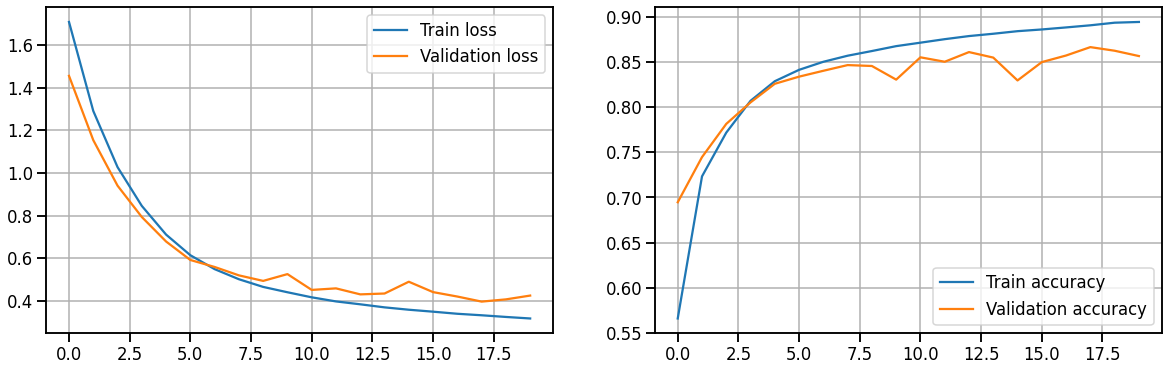

In [65]:
plot(loss_arr, loss_arr_test, acc, acc_test)

In [66]:
print("Loss: ", loss_arr_test[-1])

Loss:  0.4252659410238266


* Теперь попробуйте использовать в качестве функции активации линейную функцию. Что произошло с качеством модели?  

Можно посмотреть, где именно сетка ошибается. 

In [67]:
_, y_pred, _ = eval_nn(testloader, model_fc, loss_fn, device)
X_test = testset.data.numpy()
y_test = testset.targets.numpy()

errors = (y_pred != y_test)

# срежем только наблюдения, где была ошибка
X_err = X_test[errors]
y_err = y_test[errors]
y_pred = y_pred[errors]

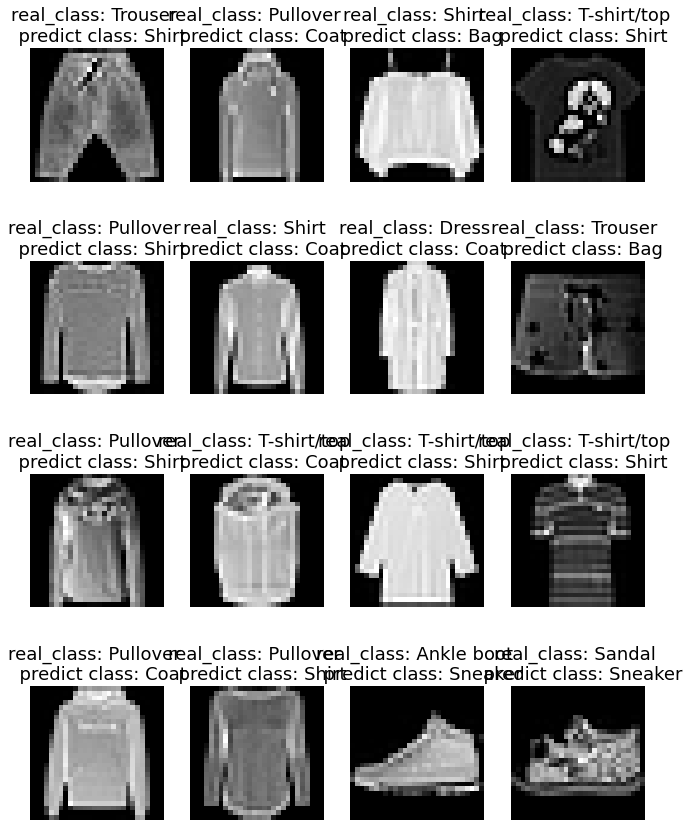

In [68]:
cols = 4
rows = 4
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_err[random_index, : ], cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(class_names[y_err[random_index]], 
                                                                   class_names[y_pred[random_index]]))
plt.show()

## 2.2 Свёрточная сетка 

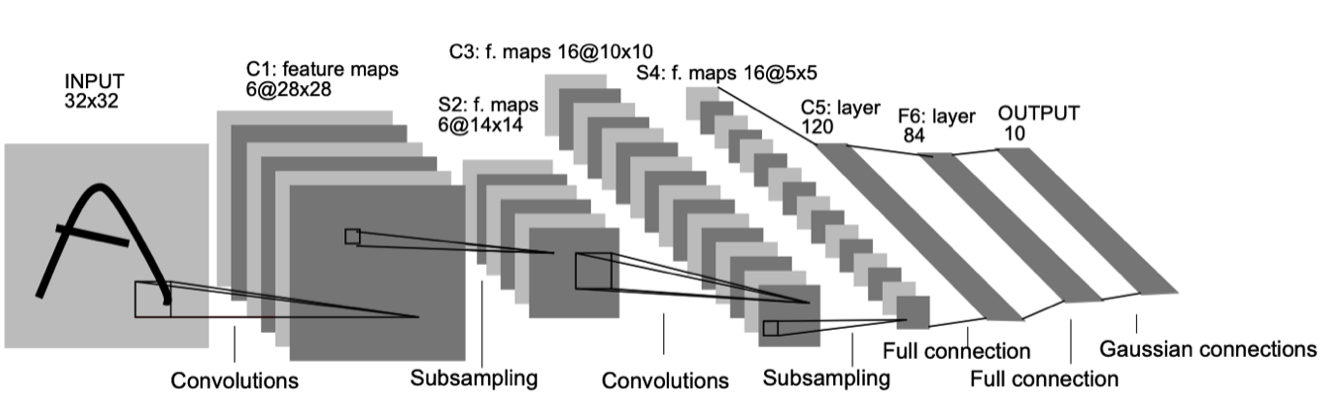

In [ ]:
display.Image('images/lenet.png', retina=True)

Также стоит держать в голове формулы для рассчета размера выхода после \
**Convolutional и Max/Avg pooling слоев:**
$$\dfrac{W−F+2P}{S}+1$$

- W is the input height/width (normally the images are squares, so there is no need to differentiate the two)
- F is the filter/kernel size
- P is the padding
- S is the stride

Теперь давайте соберём свёртоную сеть: 

* Свёртка с ядром $5 \times 5$ и $6$ каналами
* Tanh
* Avgpooling размера $2 \times 2$ с шагом (strides) $2$ по обеим осям
* Свёртка с ядром $5 \times 5$ и $16$ каналами
* Tanh
* Avgpooling размера $2 \times 2$ с шагом (strides) $2$ по обеим осям 
* Свёртка с ядром $4 \times 4$ и $120$ каналами
* Дальше сделайте `Flatten` и сделайте два полносвязных слоя с ReLU и $120$ и $84$ нейронами

Хорошая [статья](https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320) о том, как писать такую сетку на PyTorch

In [69]:
# 
#  Ваша LeNet сетка :) 
#  

class CNN(nn.Module):
    def __init__(self): 
        super().__init__()
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1), # (28-5+0)/1+1 = 24
            # nn.Batchnorm2d(6) вариант как добавить
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2), # (24-2+0)/2+1 = 12
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1), # (12-5+0)/1+1 = 8
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2), # (8-2+0)/2+1 = 4
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=4, stride=1), # (4-4+0)/1+1 = 1
            nn.Tanh())

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10))

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.reshape(x.size(0), -1)
        # перемножаем все кроме батч сайз

        logits = self.classifier(x)
        return logits

In [71]:
%%time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model_cnn = CNN()
model_cnn.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model_cnn.parameters(), lr=0.001)

loss_arr, loss_arr_test, acc, acc_test = training_loop(model_cnn, trainloader, testloader, opt, loss_fn, device, max_epochs=35)

cuda
Epoch: 0	Train loss: 1.08493	Test loss: 0.71005	Train accuracy: 62.40	Valid accuracy: 73.58
Epoch: 4	Train loss: 0.44813	Test loss: 0.46369	Train accuracy: 83.64	Valid accuracy: 83.28
Epoch: 8	Train loss: 0.37113	Test loss: 0.39346	Train accuracy: 86.49	Valid accuracy: 85.62
Epoch: 12	Train loss: 0.33046	Test loss: 0.37172	Train accuracy: 87.87	Valid accuracy: 86.14
Epoch: 16	Train loss: 0.30456	Test loss: 0.35560	Train accuracy: 88.78	Valid accuracy: 86.72
Epoch: 20	Train loss: 0.28438	Test loss: 0.33012	Train accuracy: 89.44	Valid accuracy: 87.63
Epoch: 24	Train loss: 0.26718	Test loss: 0.32260	Train accuracy: 90.07	Valid accuracy: 88.22
Epoch: 28	Train loss: 0.25357	Test loss: 0.31886	Train accuracy: 90.51	Valid accuracy: 88.03
Epoch: 32	Train loss: 0.23992	Test loss: 0.32607	Train accuracy: 91.15	Valid accuracy: 88.05
CPU times: user 6min 8s, sys: 1.96 s, total: 6min 10s
Wall time: 6min 10s


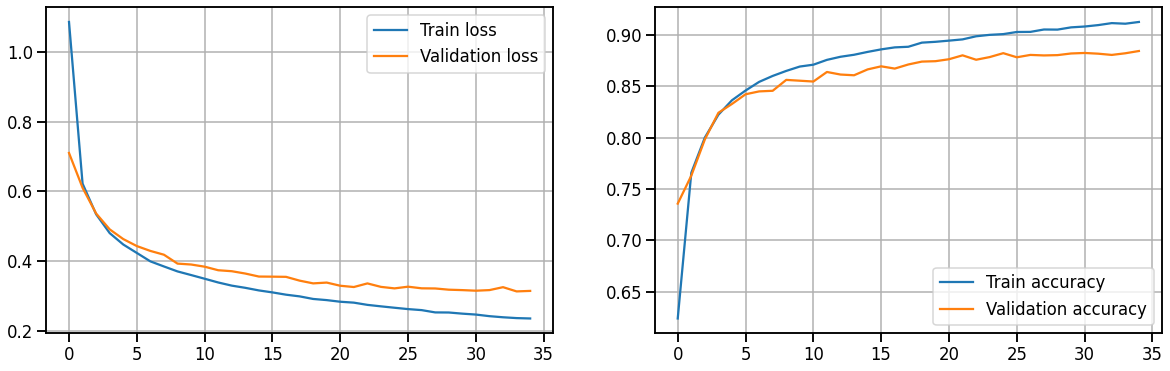

In [72]:
plot(loss_arr, loss_arr_test, acc, acc_test)

In [73]:
print("Loss: ", loss_arr_test[-1])

Loss:  0.3153753638267517


Точность должна была довольно сильно подскочить, но пока этого не произошло. \

**Домашнее задание:** 
1. добавить в pipeline расчет точности в дополнение к loss
2. улучшить качество обеих моделей (FC и CNN). В особенности CNN. Возможно, стоит изменить кол-во эпох, LR, optimizer...
3.\* Обернуть модель, функции обучения, валидации и рисования в класс. Тут нет четких критериев того, как это делать. Любые решения принимаются. Это важно для понимания того как работают классы. Можно начать с того, что поискать в интернете как обычно реализуются такие структуры.

In [ ]:
X_test.shape

In [ ]:
np.squeeze(X_test, axis=3).shape

In [ ]:
y_pred = model_2.predict_classes(X_test)
errors =  y_pred != y_test

X_err = np.squeeze(X_test[errors], axis=3)
y_err = y_test[errors]
y_pred = y_pred[errors]

In [ ]:
cols = 4
rows = 4
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_err[random_index, : ], cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(class_names[y_err[random_index]], 
                                                                   class_names[y_pred[random_index]]))
plt.show()

Вот так, кстати говоря, выглядят ошибки аналогичной неронки на MNIST. Кстати говоря, чтобы посмотреть как именно код работает на этом датасете, достаточно просто поменять первые строки с подгрузкой данных в тетрадку. 


![ ](https://raw.githubusercontent.com/FUlyankin/neural_nets_econ/master/2019/sem_6_pic/MNIST_error.png)

## Data Augmentation

Если обучить нейронку с использованием этих настроек, она никогда не увидит одно и то же изображение дважды. Однако входные данные по-прежнему будут довольно сильно связаны между собой. Мы пытаемся исказить уже существующие объекты так, чтобы они всё ещё оставались собой, но нейронка не выучивала детали, присущие конкретным наблюдениям, то есть не переобучалась.

Интересная [статья](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) из документации PyTorch на тему визуализации transformations

In [85]:
train_tfms = transforms.Compose([#transforms.RandomCrop(28), 
                                 transforms.RandomHorizontalFlip(), 
                                 transforms.RandomRotation(degrees=(0, 90)),
                                #  transforms.RandomResizedCrop(28), 
                                #  transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                 transforms.ToTensor()])
valid_tfms = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                                             download=True, 
                                             transform=train_tfms)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, 
                                            download=True, 
                                            transform=valid_tfms)

batch_size = 512
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

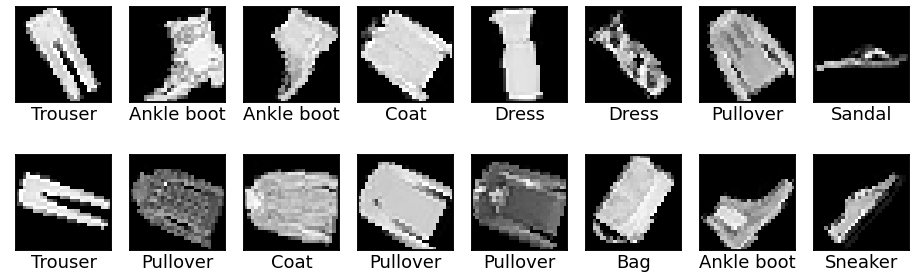

In [88]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(trainset))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(trainset[random_index][0].squeeze(), cmap = 'gray')
        ax.set_xlabel(class_names[trainset[random_index][1]])
plt.show()

Обучим сетку из предыдущего пункта на новых (аугментированных) данных.

In [89]:
%%time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model_cnn = CNN()
model_cnn.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model_cnn.parameters(), lr=0.001)

loss_arr, loss_arr_test, acc, acc_test = training_loop(model_cnn, trainloader, testloader, opt, loss_fn, device, max_epochs=35)

cuda
Epoch: 0	Train loss: 1.37425	Test loss: 1.40968	Train accuracy: 50.67	Valid accuracy: 46.41
Epoch: 4	Train loss: 0.69234	Test loss: 0.93951	Train accuracy: 73.31	Valid accuracy: 64.55
Epoch: 8	Train loss: 0.59406	Test loss: 0.77436	Train accuracy: 77.55	Valid accuracy: 71.44
Epoch: 12	Train loss: 0.53539	Test loss: 0.70764	Train accuracy: 79.98	Valid accuracy: 73.74
Epoch: 16	Train loss: 0.49220	Test loss: 0.66924	Train accuracy: 81.70	Valid accuracy: 75.52
Epoch: 20	Train loss: 0.46859	Test loss: 0.60219	Train accuracy: 82.57	Valid accuracy: 78.20
Epoch: 24	Train loss: 0.44904	Test loss: 0.60147	Train accuracy: 83.28	Valid accuracy: 78.26
Epoch: 28	Train loss: 0.43449	Test loss: 0.56601	Train accuracy: 83.76	Valid accuracy: 79.31
Epoch: 32	Train loss: 0.41629	Test loss: 0.60285	Train accuracy: 84.50	Valid accuracy: 78.31
CPU times: user 10min 35s, sys: 2.99 s, total: 10min 38s
Wall time: 10min 37s


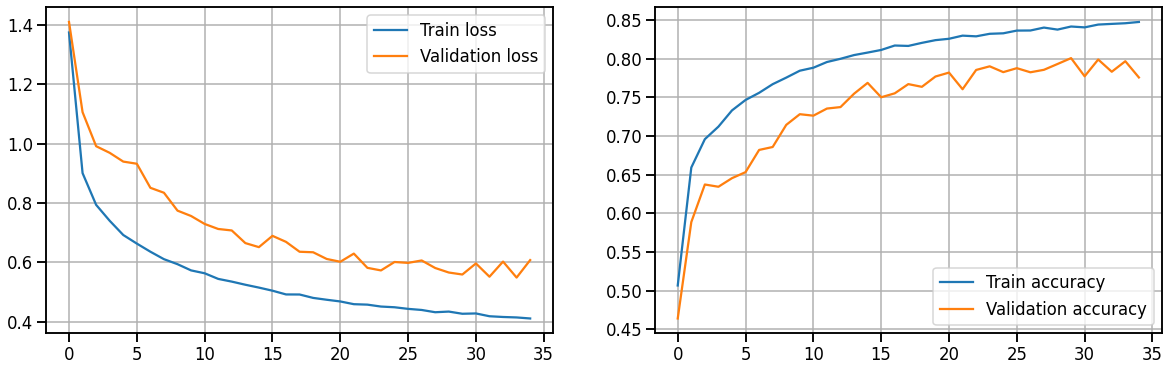

In [90]:
plot(loss_arr, loss_arr_test, acc, acc_test)

Такую сетку надо учить подольше. В этой тетрадке она реализована просто как пример аугментации данных. За реальное улучшение качества еще нужно побиться